In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!kaggle datasets download -d yasserh/imdb-movie-ratings-sentiment-analysis


  0%|          | 0.00/20.6M [00:00<?, ?B/s]
  5%|4         | 1.00M/20.6M [00:01<00:23, 872kB/s]
 10%|9         | 2.00M/20.6M [00:01<00:11, 1.73MB/s]
 19%|#9        | 4.00M/20.6M [00:01<00:04, 3.68MB/s]
 24%|##4       | 5.00M/20.6M [00:01<00:03, 4.28MB/s]
 34%|###4      | 7.00M/20.6M [00:01<00:02, 6.16MB/s]
 44%|####3     | 9.00M/20.6M [00:02<00:01, 8.05MB/s]
 54%|#####3    | 11.0M/20.6M [00:02<00:01, 8.75MB/s]
 63%|######3   | 13.0M/20.6M [00:02<00:00, 9.46MB/s]
 73%|#######2  | 15.0M/20.6M [00:02<00:00, 9.65MB/s]
 83%|########2 | 17.0M/20.6M [00:02<00:00, 10.3MB/s]
 92%|#########2| 19.0M/20.6M [00:03<00:00, 10.1MB/s]
100%|##########| 20.6M/20.6M [00:03<00:00, 10.2MB/s]
100%|##########| 20.6M/20.6M [00:03<00:00, 6.75MB/s]


In [3]:
from zipfile import ZipFile
dataset = 'imdb-movie-ratings-sentiment-analysis.zip'
with ZipFile(dataset, 'r') as zip:
    zip.extractall()
    print("the dataset is extracted")

the dataset is extracted


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_csv('movie.csv')

In [3]:
data.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [4]:
#1= good, 0 = bad

In [5]:
data.isnull().sum()

text     0
label    0
dtype: int64

In [6]:
data.duplicated().sum()

277

In [7]:
data.drop_duplicates(inplace = True)

In [8]:
data.duplicated().sum()

0

In [9]:
data.shape

(39723, 2)

In [10]:
data['label'].value_counts()

1    19908
0    19815
Name: label, dtype: int64

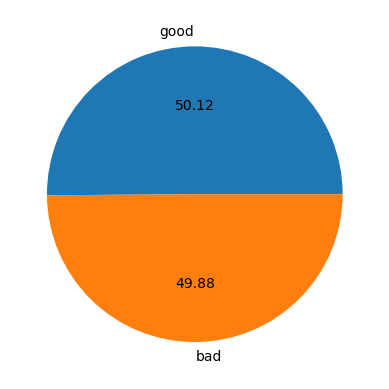

In [11]:
plt.pie(data['label'].value_counts(), labels=['good', 'bad'], autopct="%0.2f")
plt.show()

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
ps = PorterStemmer()

In [14]:
def preprocess(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y=[]
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    return " ".join(y)
    
            

In [15]:

preprocess("HIII HIII and the ddjk dancing ")

'hiii hiii ddjk danc'

In [16]:
data['text'] = data['text'].apply(preprocess)

In [17]:
data.head()

,text,label
0,grew b 1965 watch love thunderbird mate school...,0
1,put movi dvd player sat coke chip expect hope ...,0
2,peopl know particular time past like feel need...,0
3,even though great interest biblic movi bore de...,0
4,im die hard dad armi fan noth ever chang got t...,1


In [97]:
data.to_csv('processed_movie.csv')

In [18]:
data['label'].values

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [19]:
from tensorflow.keras.layers import TextVectorization
import tensorflow as tf


In [20]:
X = data['text']
y = data['label'].values

In [21]:
vectorizer = TextVectorization(max_tokens = 100000,
                               output_sequence_length = 1500,
                               output_mode = 'int')

In [22]:
vectorizer.adapt(X.values)

In [23]:
vectorizer('Hello')

<tf.Tensor: shape=(1500,), dtype=int64, numpy=array([3886,    0,    0, ...,    0,    0,    0], dtype=int64)>

In [24]:
X = vectorizer(X.values)

In [25]:
#pipeline
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [26]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [27]:
batch_X.shape, batch_y.shape

((16, 1500), (16,))

In [28]:
train = dataset.take(int(len(dataset)*0.7))
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout

In [30]:
model = Sequential()
model.add(Embedding(100000+1, 32)) # this will create embedding like word2vec max_features+1 = columns, 32 will be features(rows)which will be created according to the rows(vacabulary)
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
    #last is O/p layer
model.add(Dense(1, activation='sigmoid')) #units are 1 because final o/p contains 1 choices


In [31]:
model.compile(loss = 'BinaryCrossentropy', optimizer = 'adam')

In [32]:
model.fit(train, epochs=7, validation_data=val)

Epoch 1/7
1738/1738 [==============================] - 1290s 738ms/step - loss: 0.3857 - val_loss: 0.2063
Epoch 2/7
1738/1738 [==============================] - 1263s 727ms/step - loss: 0.2278 - val_loss: 0.1643
Epoch 3/7
1738/1738 [==============================] - 1214s 698ms/step - loss: 0.1797 - val_loss: 0.1430
Epoch 4/7
1738/1738 [==============================] - 1193s 686ms/step - loss: 0.1743 - val_loss: 0.6400
Epoch 5/7
1738/1738 [==============================] - 1197s 689ms/step - loss: 0.1671 - val_loss: 0.0805
Epoch 6/7
1738/1738 [==============================] - 1197s 689ms/step - loss: 0.1075 - val_loss: 0.0706
Epoch 7/7
1738/1738 [==============================] - 1293s 744ms/step - loss: 0.0734 - val_loss: 0.0507


In [33]:
input = vectorizer('The 5 years was worth the wait. Amazing animation, beautiful characters with rich backstories, the fights are amazing, Gwens story is amazing, EVERYTHING IS AMAZING! This entire movie is gorgeous and keeps you hooked and almost forces you to continue watching, thats how amazing it is. The hype around this movie was 100% deserved and made sense, seeing as how this movie may be the greatest film I have ever seen.')

In [34]:
res = model.predict(np.expand_dims(input, 0))

1/1 [==============================] - 1s 951ms/step


In [35]:

print(res)

[[0.9987258]]


In [36]:
if res>0.5:
    print('posit')
else:
    print('neg')

posit


# Saving The Model!

In [83]:
from tensorflow.keras.models import load_model
import os

In [39]:
model.save(os.path.join('Model', 'MovieSentiment.h5'))

# To Reload The Model

In [40]:
new_model = load_model(os.path.join('Model', 'MovieSentiment.h5'))

In [72]:
input = preprocess('Perfect')
text = vectorizer(input)

In [73]:
output = new_model.predict(np.expand_dims(text, 0))
output

1/1 [==============================] - 0s 65ms/step


array([[0.9633324]], dtype=float32)

In [74]:
if output > 0.7:
    print("Positive")
if output <0.7 and output > 0.4:
    print('Average')
else:
    print("Negative")

Positive
Negative
